In [76]:
%load_ext autoreload
%autoreload 2
from mod_3_project import *
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1><center>An analysis of grade distributions at UW-Madison</center></h1>
<h2><center>by Max Schulte and Nicholas Schafer</center></h2>

<img src="memorialterrace.jpg">

### Are you an incoming freshman at UW-Madison who is looking to avoid the ill-effects of fluctuating grade distributions? You may be in luck. In this project, we analyze the influence of several factors on grades distributed at UW-Madison including time of day and instructor.

## Introduction to the data set

We performed on our analyses on a data set that was [uploaded to Kaggle](https://www.kaggle.com/Madgrades/uw-madison-courses). The underlying data was provided by the UW-Madison registrar in PDF form. The folks at [madgrades](https://madgrades.com/) extracted the data from the PDFs and made an awesome website where you can explore the data set. [Check it out](https://madgrades.com/). Here, we are asking some questions that are not addressed on the site, which we will describe below.

A few pieces of vocabulary: a *course* can be taught over multiple years and by different instructors. A *course offering* refers to a specific time that a course was taught. Each course offering has a distribution of grades, and it is those distributions that we will be analyzing.

## Introduction to grade distributions

Grades at UW-Madison are given a little differently than they are at some other institutions. The letter grades that a student can receive (and the corresponding grade points awarded) are:
- A (4.0)
- AB (3.5)
- B (3.0)
- BC (2.5)
- C (2.0)
- D (1.0)
- F (0.0)

There are no "CD" or "DF" grades.

Although not all courses at UW-Madison give students letter grades, we will be focused on those courses that do give letter grades. At the end of the course, there will be a certain number of As, ABs, Bs, etc. given out to students. We will represent these grade distributions in two different ways: as probability mass (or density) functions (PMF/PDF) or as cumulative mass (or density) functions (CMF/CDF). The term "mass" (as opposed to "density) is typically used for discrete distributions, which is what we are dealing with here. We may use mass and density interchangeably, however, because, unlike some other discrete distributions, our outcomes can be sensibly ordered (by the number of grade points associated with the letter grades) and therefore we can compute a CDF like we normally would for a continuous distribution. Treating this discrete distribution as if it were continuous will allow us to compute statistics and apply statistical tests that were developed for continuous distributions (with some caution and care).

## Introduction to grade distributions

Suppose you are in a class with 18 students and 0 students get Fs, 1 student gets a D, 2 students get Cs, 3 students get BCs, 5 students get Bs, 4 students get ABs, and 3 students get As. 
The grade probability density function is then computed as

$$ PDF(Grade)=\frac{\text{# of each particular grade given}}{\text{total # of grades given}} $$

When plotted, the grade probability density function for the class mentioned above looks like:

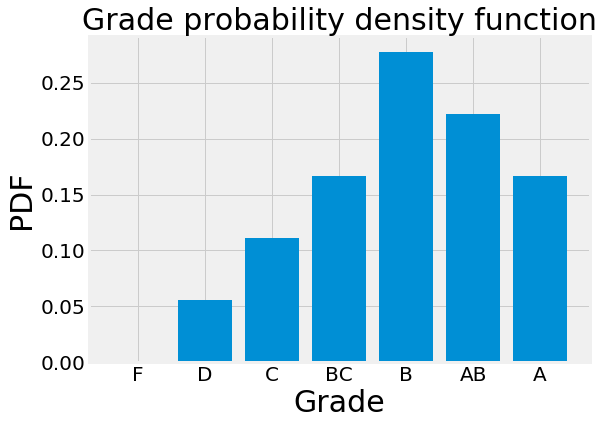

In [77]:
plot_grade_distribution([0, 1, 2, 3, 5, 4, 3], barplot=True, lineplot=False, distribution_type='pdf')

We will sometimes want to overlay multiple distributions, in which case it will be easier to plot the PDF using a line, as shown below:

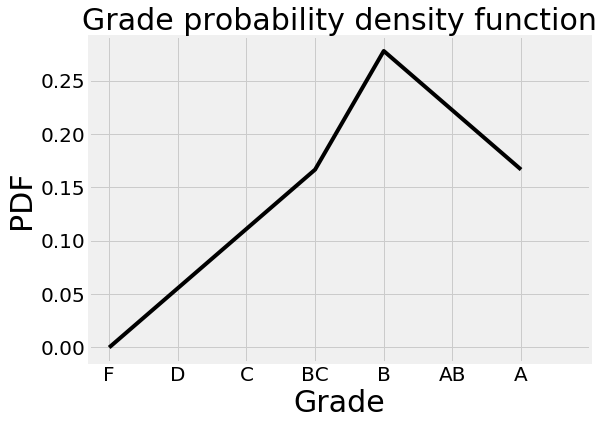

In [78]:
plot_grade_distribution([0, 1, 2, 3, 5, 4, 3], barplot=False, lineplot=True, distribution_type='pdf')

The grade cumulative distribution function is computed as

$$ CDF(Grade)=\sum_{Grades \leq Grade} PDF(Grade) $$

where $Grades \leq Grade$ refers to all grades that give the same or fewer grade points. The corresponding CDF for the above PDF looks like:

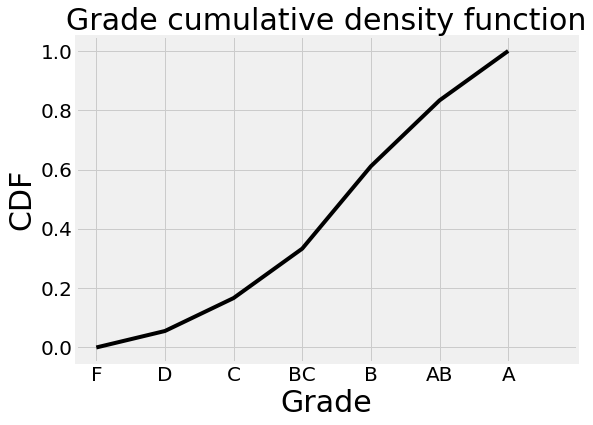

In [79]:
plot_grade_distribution([0, 1, 2, 3, 5, 4, 3], barplot=False, lineplot=True, distribution_type='cdf')

These grade distributions can be plotted for individual courses or for groups of courses by simply aggregating the results from multiple courses. Having compiled the grade distribution functions, we can either compare two (or more) grade distributions or use them to compute summary statistics such as the average grade for a class. We will show examples of both of these cases below.

## Do different instructors distribute grades differently when teaching the same courses?

Unless there is a strict policy regarding how grades should be distributed (in what proportion), then, naturally, different grade distributions will result when a given course is taught multiple times. Can we ever attribute these differences to the instructor? If so, how do we do this and with what certainty can we claim that different instructors distribute grades differently? 

## Are grades distributed differently depending upon the time of day?

There may be many reasons why different grade distributions might arise for classes starting at different times throughout the day, but is there any evidence for this?

### Importing Data

In [80]:
from sql_helper import *

In [81]:
import sys
# connect to db if possible 
conn, err = con_sql("database.sqlite3")
if err is not None:
    print(err)
    sys.exit()
c = conn.cursor()

Upon importing the grade distribution data, it is easy to see that there is a data that will not be used when what is interesting is the grade count for each letter grade.  The start time is also irrelevant to the analysis. These will all be filtered later but it is important to keep in mind what is needed for the analysis.

In [82]:
df = sql_frame("grade_distributions", conn)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193262 entries, 0 to 193261
Data columns (total 18 columns):
course_offering_uuid    193262 non-null object
section_number          193262 non-null object
n_count                 193262 non-null object
c_count                 193262 non-null object
f_count                 193262 non-null object
cr_count                193262 non-null object
p_count                 193262 non-null object
nw_count                193262 non-null object
other_count             193262 non-null object
bc_count                193262 non-null object
u_count                 193262 non-null object
d_count                 193262 non-null object
ab_count                193262 non-null object
a_count                 193262 non-null object
s_count                 193262 non-null object
i_count                 193262 non-null object
b_count                 193262 non-null object
nr_count                193262 non-null object
dtypes: object(18)
memory usage: 26.5+ MB


The section table is also needed in order to access the schedule data through the section's schedule id so it is needed as an intermediary merge step.

In [83]:
sections_df = sql_frame("sections", conn)
df = pd.merge(df, sections_df, how="right", on=["course_offering_uuid"])
del sections_df

The column name to merge on, "uuid", is not the same in both tables so it must be changed in the schedules table to match the grade distributions table's "schedule_uuid"

In [84]:
schedules_df = sql_frame("schedules", conn)
schedules_df.columns = [
    "schedule_uuid" if i == "uuid" else i for i in schedules_df.columns
]
df = pd.merge(df, schedules_df, how="outer", on=["schedule_uuid"])
del schedules_df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135901 entries, 0 to 2135900
Data columns (total 32 columns):
course_offering_uuid    object
section_number          object
n_count                 object
c_count                 object
f_count                 object
cr_count                object
p_count                 object
nw_count                object
other_count             object
bc_count                object
u_count                 object
d_count                 object
ab_count                object
a_count                 object
s_count                 object
i_count                 object
b_count                 object
nr_count                object
uuid                    object
section_type            object
number                  object
room_uuid               object
schedule_uuid           object
start_time              object
end_time                object
mon                     object
tues                    object
wed                     object
thurs              

After everything has been merged and the schedules are now linked to the grade distribution, it is now time to keep only items relevant to the analysis

In [85]:
important_grades = [
    "f_count",
    "d_count",
    "c_count",
    "bc_count",
    "b_count",
    "ab_count",
    "a_count",
]

# course_offering_uuid is needed for a later join
df = df[[*important_grades, "start_time", "course_offering_uuid"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135901 entries, 0 to 2135900
Data columns (total 9 columns):
f_count                 object
d_count                 object
c_count                 object
bc_count                object
b_count                 object
ab_count                object
a_count                 object
start_time              object
course_offering_uuid    object
dtypes: object(9)
memory usage: 163.0+ MB


### Cleaning Data

Now that all of the data is successfully merged it is time to start looking into how to get the data into the correct format to be processed.  To start with the start time is of string time instead of a time.  Ideally the start time should be a float64 value between 0 and 24 hours.  There are also nan values and -1 placeholders which should be removed from the analysis.

In [86]:
pd.unique(df["start_time"])

array(['-1', '530', '660', '800', '725', '865', '595', '930', '870',
       '1040', '995', '1050', '960', '935', '720', '1140', '945', '1170',
       '1110', '1215', '780', '570', '480', '1080', '465', '840', '1020',
       '810', '1125', '1060', '540', '630', '990', '900', '1055', '985',
       '1025', '795', '1005', '505', '1065', '460', '600', '750', '390',
       '1095', '825', '495', '655', '1145', '1190', '735', '775', '615',
       '1155', '975', '575', '1030', '645', '820', '1115', '1015', '1200',
       '1035', '1185', '535', '1010', '915', '980', '560', '1045', '885',
       '905', '510', '785', '722', '580', '860', '875', '790', '805',
       '740', '525', '890', '435', '920', '940', '515', '555', '850',
       '745', '760', '1100', '585', '955', '665', '925', '855', '705',
       '710', '770', '965', '485', '565', '675', '690', '765', '610',
       '1000', '730', '880', '1160', '950', '640', '450', '830', '590',
       '620', '670', '680', '1260', '550', '895', '970', '420'

In [87]:
# clean_non_time is faster way of getting rid of non numerics
def clean_non_time(x):
    if type(x) is not str:
        return None
    result = int(x)
    if result < 0:
        return None
    return result

df["start_time"] = df["start_time"].apply(clean_non_time)
df = df.dropna()

Since the start time is in minutes it would be more human readable to convert to hours

In [88]:
df["start_time"] = df["start_time"].apply(
    lambda x: int(x) / 60
)
df = df.dropna()
sorted(pd.unique(df["start_time"]))

[0.5,
 1.1666666666666667,
 2.5,
 5.5,
 6.0,
 6.5,
 7.0,
 7.25,
 7.333333333333333,
 7.5,
 7.583333333333333,
 7.666666666666667,
 7.75,
 7.833333333333333,
 7.916666666666667,
 8.0,
 8.083333333333334,
 8.166666666666666,
 8.25,
 8.333333333333334,
 8.416666666666666,
 8.5,
 8.583333333333334,
 8.666666666666666,
 8.75,
 8.833333333333334,
 8.916666666666666,
 9.0,
 9.083333333333334,
 9.166666666666666,
 9.25,
 9.333333333333334,
 9.416666666666666,
 9.5,
 9.583333333333334,
 9.666666666666666,
 9.75,
 9.833333333333334,
 9.916666666666666,
 10.0,
 10.083333333333334,
 10.166666666666666,
 10.25,
 10.333333333333334,
 10.416666666666666,
 10.5,
 10.583333333333334,
 10.666666666666666,
 10.75,
 10.833333333333334,
 10.916666666666666,
 11.0,
 11.083333333333334,
 11.166666666666666,
 11.25,
 11.333333333333334,
 11.416666666666666,
 11.5,
 11.583333333333334,
 11.666666666666666,
 11.75,
 11.833333333333334,
 11.916666666666666,
 12.0,
 12.033333333333333,
 12.083333333333334,
 12.16

Since there are some unreasonable class times it would be reasonable to remove data before 6 AM

In [89]:
df = df.loc[df["start_time"] > 6]
sorted(pd.unique(df["start_time"]))

[6.5,
 7.0,
 7.25,
 7.333333333333333,
 7.5,
 7.583333333333333,
 7.666666666666667,
 7.75,
 7.833333333333333,
 7.916666666666667,
 8.0,
 8.083333333333334,
 8.166666666666666,
 8.25,
 8.333333333333334,
 8.416666666666666,
 8.5,
 8.583333333333334,
 8.666666666666666,
 8.75,
 8.833333333333334,
 8.916666666666666,
 9.0,
 9.083333333333334,
 9.166666666666666,
 9.25,
 9.333333333333334,
 9.416666666666666,
 9.5,
 9.583333333333334,
 9.666666666666666,
 9.75,
 9.833333333333334,
 9.916666666666666,
 10.0,
 10.083333333333334,
 10.166666666666666,
 10.25,
 10.333333333333334,
 10.416666666666666,
 10.5,
 10.583333333333334,
 10.666666666666666,
 10.75,
 10.833333333333334,
 10.916666666666666,
 11.0,
 11.083333333333334,
 11.166666666666666,
 11.25,
 11.333333333333334,
 11.416666666666666,
 11.5,
 11.583333333333334,
 11.666666666666666,
 11.75,
 11.833333333333334,
 11.916666666666666,
 12.0,
 12.033333333333333,
 12.083333333333334,
 12.166666666666666,
 12.25,
 12.333333333333334,
 

Something that also must be done is convert the grade counts to numberic types.  It is also important to consider classes where there are no letter grades, these can also be dropped.

In [90]:
df[important_grades] = df[important_grades].apply(lambda x: pd.to_numeric(x))
df = df.dropna()

In [91]:
df = df.loc[
    (df["c_count"] > 0)
    | (df["f_count"] > 0)
    | (df["bc_count"] > 0)
    | (df["d_count"] > 0)
    | (df["ab_count"] > 0)
    | (df["a_count"] > 0)
]

### Data Transformation

It is much easier for the for humans to wrap their head around a GPA instead of a grade count to it would be best to take steps to calculate this value for each class.  First a total must be computed for each of the grades.  From their a ratio of each grade count to the total of the grades.  The GPA can then be calculated by taking the dot product of the grade ratios with the GPA scale of the grades

In [92]:
grades = df[important_grades].copy()
df["total"] = grades.sum(axis=1)
important_grades_ratios = list(map(lambda x: x + "_ratio", important_grades))
df[important_grades_ratios] = grades[important_grades].apply(lambda x: x / df["total"])

In [93]:
gpa_scale = np.array([0, 1, 2, 2.5, 3, 3.5, 4], dtype="float32")
df["gpa"] = df[important_grades_ratios].apply(lambda x: np.dot(x, gpa_scale), axis=1)

Since there are many different start times it would be helpful to see the start times by which hour of the day that the class starts in

In [94]:
df["hour_within"] = df["start_time"].apply(lambda x: x // 1)

In [95]:
df.head()

,f_count,d_count,c_count,bc_count,b_count,ab_count,a_count,start_time,course_offering_uuid,total,f_count_ratio,d_count_ratio,c_count_ratio,bc_count_ratio,b_count_ratio,ab_count_ratio,a_count_ratio,gpa,hour_within
1268407,0,0,0,0,0,0,46,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,46,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,8.0
1268408,0,0,0,0,0,0,41,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,41,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,4.000000,8.0
1268409,0,0,0,0,1,5,13,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.052632,0.263158,0.684211,3.815789,8.0
1268410,0,0,0,0,2,6,11,8.833333,a71789f0-09d9-3374-bd21-04a719a62af8,19,0.0,0.0,0.0,0.0,0.105263,0.315789,0.578947,3.736842,8.0
1268411,0,0,0,0,0,2,23,8.833333,cb14977e-d147-3110-8bf0-83c363730609,25,0.0,0.0,0.0,0.0,0.000000,0.080000,0.920000,3.960000,8.0


### Gouping Data

Now that the data contains GPA information and which hour the class falls withing, the next step to the analysis would be to group by the hour that the class starts within for comparison between each hour.

In [96]:
# group
gpa_within_hour = df[["gpa", "hour_within"]].groupby("hour_within") 

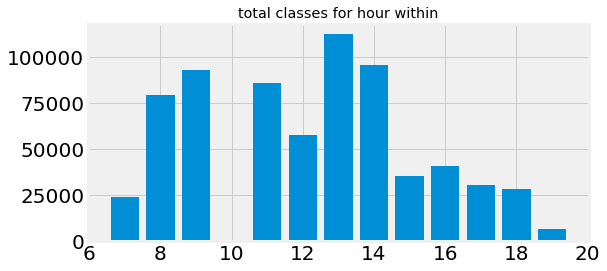

In [115]:
plt.figure(figsize=(8,4 ))
lens = []
for i in gpa_within_hour:
    lens.append(len(i[1]))
plt.bar(list(gpa_within_hour.groups.keys()), lens)
plt.title("total classes for hour within")
plt.show()

there are some time groups that do not have enough data comparatively so they will be rejected

In [98]:
gpa_within_hour = gpa_within_hour.filter(lambda x: len(x) > 5000)
# regroup
gpa_within_hour = gpa_within_hour[["gpa", "hour_within"]].groupby("hour_within") 

### Figures and Observations

##### Distribution of All Grades over Time for a Given Start Time observations
* most times have a significant amount of outliers on the low side of the GPA's for each hour
* GPA's are skewed towards higher GPA's as shown by the short right wisker and long left whiskers
* mean GPA's show the most variance towards the beginning and the end of the day
* times during the middle of the day show the most outliers

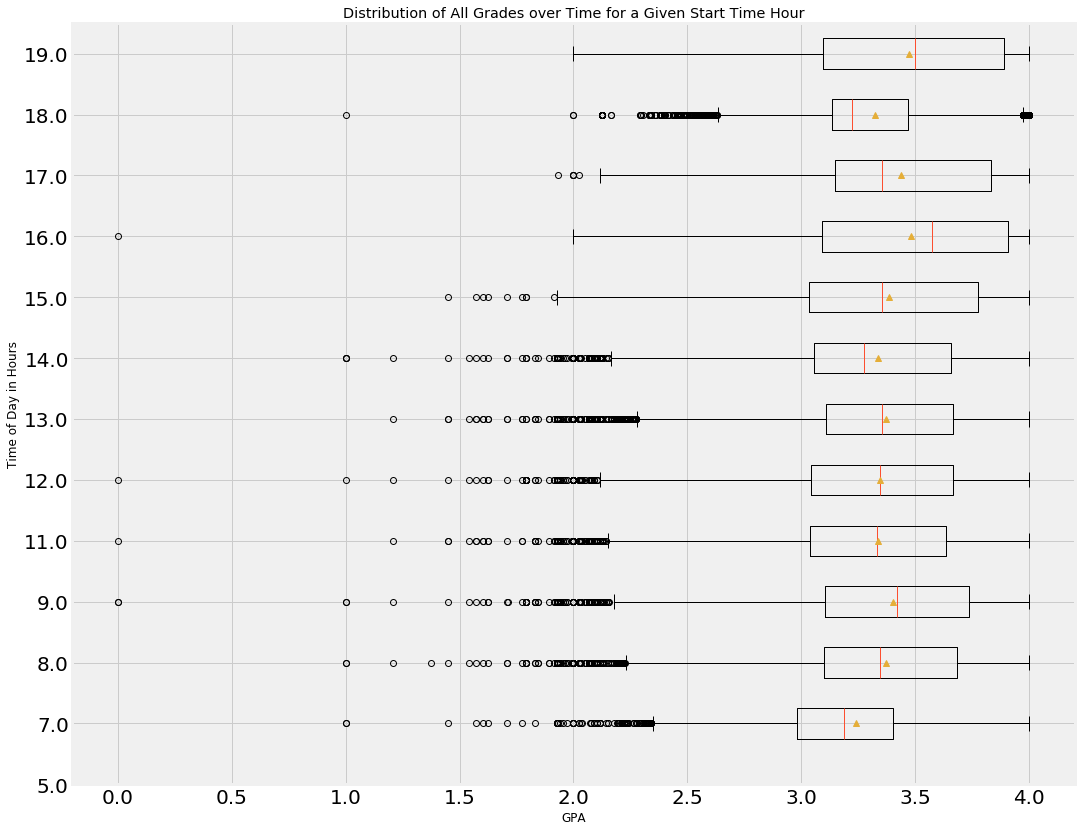

In [99]:
plt.figure(figsize=(16,14))
hours = [5.0]
boxes=[]
for i, hour_gpas in enumerate(gpa_within_hour):
    hours.append(hour_gpas[0])
    boxes.append(hour_gpas[1]["gpa"])
plt.title("Distribution of All Grades over Time for a Given Start Time Hour")
plt.ylabel("Time of Day in Hours")
plt.xlabel("GPA")
plt.boxplot(boxes, vert=0, showmeans=True)
plt.yticks(range(len(hours)), hours)
plt.show()
plt.close()

### Resampling Analysis

In [100]:
gpa_within_hour_mean = gpa_within_hour.apply(lambda x: x.mean())
gpa_within_hour_samples_means = []
for i in range(100):
    gwhsm = gpa_within_hour.obj.sample(len(gpa_within_hour.obj), replace=True)
#     print(len(gwhsm.loc[gwhsm["hour_within"] == 8.0]))
#     plt.hist(gwhsm.loc[gwhsm["hour_within"] == 8.0]["gpa"])
#     break
    gwhsm = gwhsm.groupby("hour_within").apply(lambda x: x.mean())
    gpa_within_hour_samples_means.append(gwhsm)

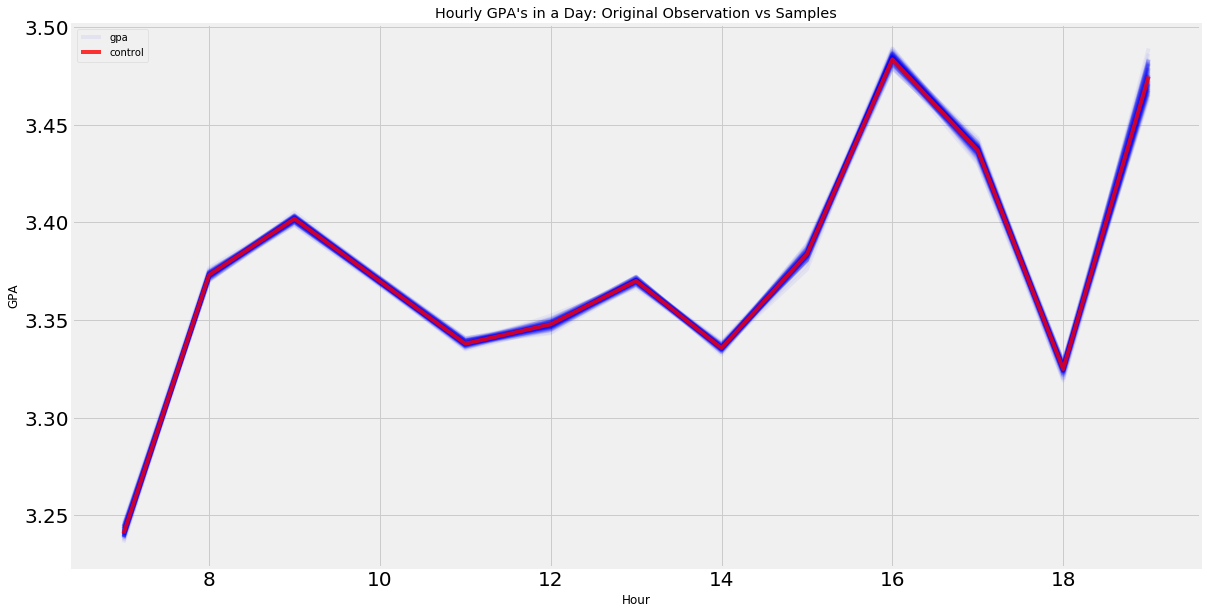

In [101]:
plt.figure(figsize=(18,10))
a = .05
for i, gwhsm in enumerate(gpa_within_hour_samples_means):
    if i == 0:
        plt.plot(gwhsm["gpa"], alpha=a, color="blue")
        continue
    plt.plot(gwhsm["gpa"], alpha=a, color="blue", label="")

plt.xlabel("Hour")
plt.ylabel("GPA")
plt.plot(gpa_within_hour_mean["gpa"], alpha=0.8, label="control", color="red")
plt.title("Hourly GPA's in a Day: Original Observation vs Samples")
plt.legend(loc="upper left")
plt.show()

## Grouped By Term Analysis

In [102]:
course_offerings_df = sql_frame("course_offerings", conn)
course_offerings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81453 entries, 0 to 81452
Data columns (total 4 columns):
uuid           81453 non-null object
course_uuid    81453 non-null object
term_code      81453 non-null object
name           81453 non-null object
dtypes: object(4)
memory usage: 2.5+ MB


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695766 entries, 1268407 to 2080599
Data columns (total 19 columns):
f_count                 695766 non-null int64
d_count                 695766 non-null int64
c_count                 695766 non-null int64
bc_count                695766 non-null int64
b_count                 695766 non-null int64
ab_count                695766 non-null int64
a_count                 695766 non-null int64
start_time              695766 non-null float64
course_offering_uuid    695766 non-null object
total                   695766 non-null int64
f_count_ratio           695766 non-null float64
d_count_ratio           695766 non-null float64
c_count_ratio           695766 non-null float64
bc_count_ratio          695766 non-null float64
b_count_ratio           695766 non-null float64
ab_count_ratio          695766 non-null float64
a_count_ratio           695766 non-null float64
gpa                     695766 non-null float64
hour_within             695766 non-

In [105]:
course_offerings_df.columns = list(
    map(
        lambda x:  "course_offering_uuid" if x == "uuid" else x, course_offerings_df.columns
    )
)

In [106]:
grades_to_term_df = pd.merge(course_offerings_df, df, how="right",on=["course_offering_uuid"])

In [109]:
terms_gdf = grades_to_term_df.groupby("term_code")

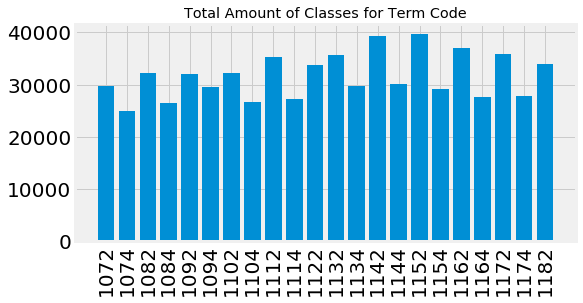

In [117]:
plt.figure(figsize=(8,4))
lens = []
for i in terms_gdf:
    lens.append(len(i[1]))
plt.xticks(rotation=90)
plt.title("Total Amount of Classes for Term Code")
plt.bar(list(terms_gdf.groups.keys()), lens)
plt.show()

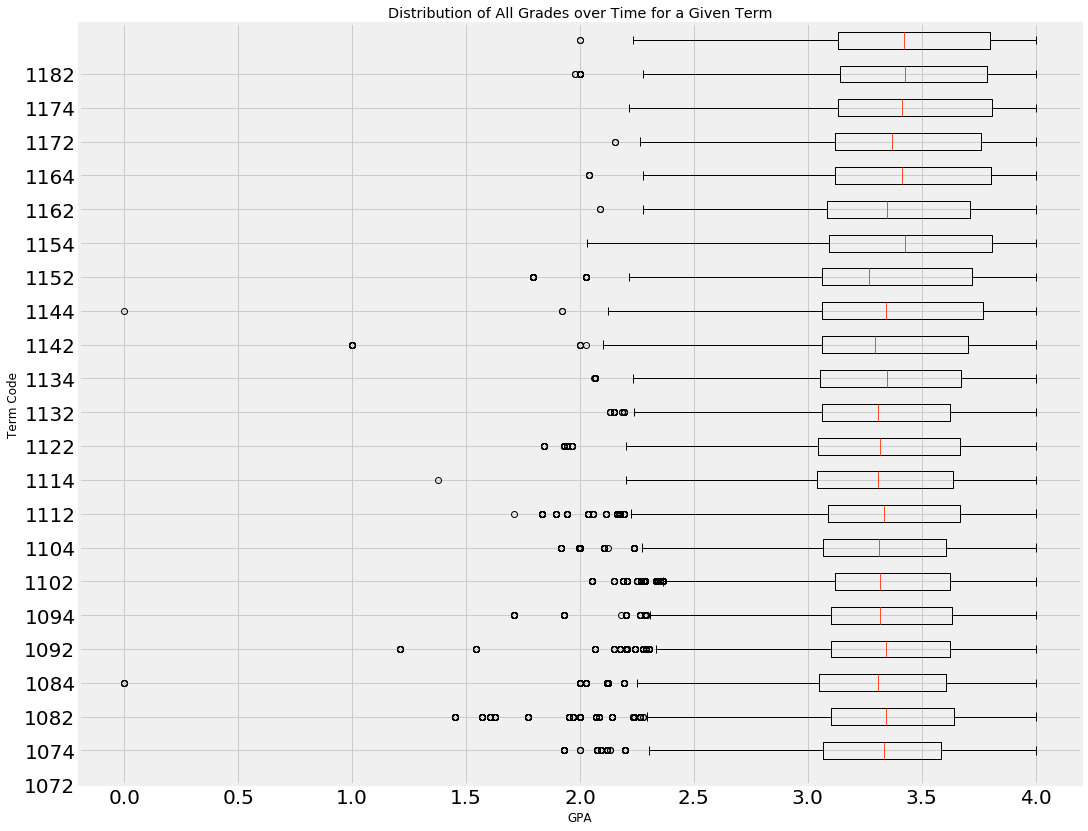

In [118]:
plt.figure(figsize=(16,14))
terms = []
boxes=[]
for i, hour_gpas in enumerate(terms_gdf):
    terms.append(hour_gpas[0])
    boxes.append(hour_gpas[1]["gpa"])
plt.title("Distribution of All Grades over Time for a Given Term")
plt.ylabel("Term Code")
plt.xlabel("GPA")
plt.boxplot(boxes, vert=0)
plt.yticks(range(len(terms)), terms)
plt.show()
plt.close()

In [119]:
gpa_term_means = terms_gdf["gpa"].apply(lambda x: x.mean())
gpa_term_samples_means = []
for i in range(100):
    gtsm = terms_gdf.obj.sample(int(terms_gdf.obj.shape[0] * 1), replace=True)
    gtsm = gtsm.groupby("term_code")["gpa"].apply(lambda x: x.mean())
    gpa_term_samples_means.append(gtsm)

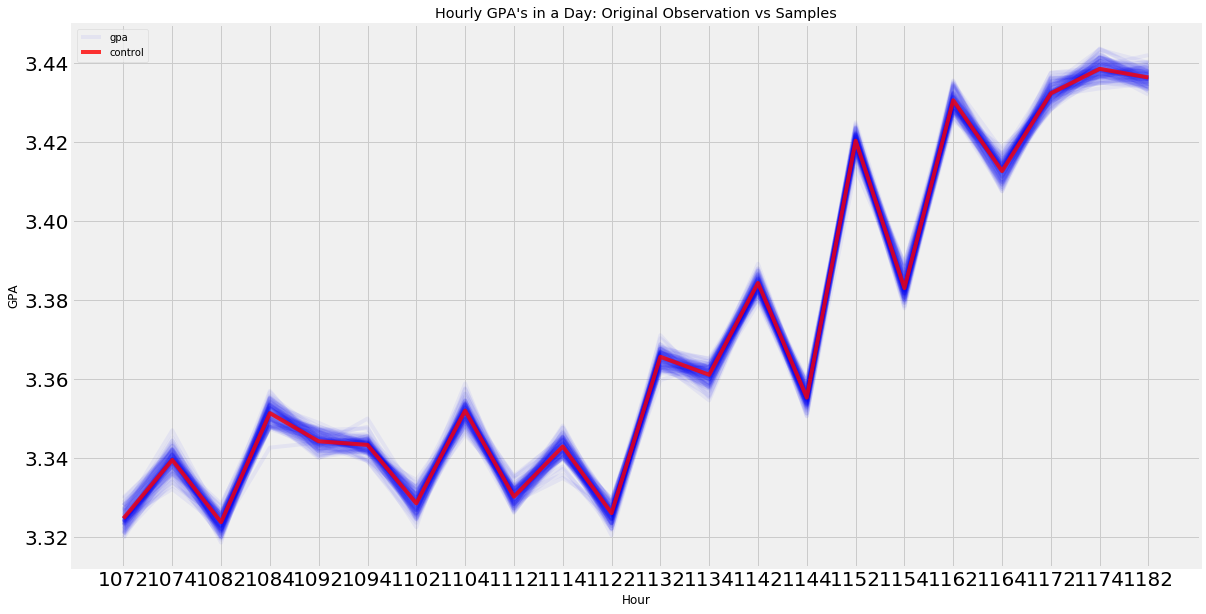

In [120]:
plt.figure(figsize=(18,10))

for i, gwhsm in enumerate(gpa_term_samples_means):
    if i == 0:
        plt.plot(gwhsm, alpha=0.05, color="blue")
        continue
    plt.plot(gwhsm, alpha=0.05, color="blue", label="")

plt.xlabel("Hour")
plt.ylabel("GPA")
plt.plot(gpa_term_means, alpha=0.8, label="control", color="red")
plt.title("Hourly GPA's in a Day: Original Observation vs Samples")
plt.legend(loc="upper left")
plt.show()

### Data query and cleaning

Conveniently, Kaggle provides a sqlite database containing the Madgrades data. Our friend Alan Hong kindly built this schema for the database using [dbdiagram.io](https://dbdiagram.io/home).

<img src="alan-schema.png" width=70%>

Alan's manual annotation of the related keys in the different tables make it easy to put together the appropriate SQL query, which we pass through the sqlite3 Python package to retrieve our data and put it into a Pandas dataframe for further processing. The wrapper functions used here and throughout the notebook can be found in the mod_3_project.py file in this repository.

In [5]:
conn = sqlite3.connect('database.sqlite3')
c = conn.cursor()

In [6]:
df = sql_to_pandas_df("""SELECT co.course_uuid as course_uuid,
                    c.name as course_name,
                    c.number as course_number,
                    g.course_offering_uuid as course_offering_uuid,
                    s.section_type as section_type,
                    co.term_code as course_offering_term_code,
                    t.instructor_id as instructor_id,
                    i.name as instructor_name,
                    su.name as subject_name,
                    su.code as subject_code,
                    g.a_count as a_count,
                    g.ab_count as ab_count,
                    g.b_count as b_count,
                    g.bc_count as bc_count,
                    g.c_count as c_count,
                    g.d_count as d_count,
                    g.f_count as f_count
                     FROM grade_distributions g
                     JOIN course_offerings co ON g.course_offering_uuid = co.uuid
                     JOIN sections s ON co.uuid = s.course_offering_uuid
                     JOIN teachings t ON t.section_uuid = s.uuid
                     JOIN courses c ON c.uuid = co.course_uuid
                     JOIN instructors i ON i.id = t.instructor_id
                     JOIN subject_memberships sm ON sm.course_offering_uuid = co.uuid
                     JOIN subjects su ON su.code = sm.subject_code
                     """, c)

In [7]:
len(df)

2206765

Initially, there are more than 2 million rows in our resulting dataframe. Since we are interested in courses that issue letter grades, we can filter out any rows for which the sum of all of the letter grade counts is zero. Although not strictly necessary, this can be made slightly easier by first creating a new column with the total number of letter grades. Also, since we are starting to mathematically manipulate the data, we may as well cast all of the letter grade counts to integers.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206765 entries, 0 to 2206764
Data columns (total 17 columns):
course_uuid                  object
course_name                  object
course_number                object
course_offering_uuid         object
section_type                 object
course_offering_term_code    object
instructor_id                object
instructor_name              object
subject_name                 object
subject_code                 object
a_count                      object
ab_count                     object
b_count                      object
bc_count                     object
c_count                      object
d_count                      object
f_count                      object
dtypes: object(17)
memory usage: 286.2+ MB


In [9]:
convert_grades_to_ints(df)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206765 entries, 0 to 2206764
Data columns (total 17 columns):
course_uuid                  object
course_name                  object
course_number                object
course_offering_uuid         object
section_type                 object
course_offering_term_code    object
instructor_id                object
instructor_name              object
subject_name                 object
subject_code                 object
a_count                      int64
ab_count                     int64
b_count                      int64
bc_count                     int64
c_count                      int64
d_count                      int64
f_count                      int64
dtypes: int64(7), object(10)
memory usage: 286.2+ MB


In [11]:
add_total_grades(df)

In [12]:
df = filter_no_grades(df)

In [13]:
len(df)

860334

We're now left with about 900,000 rows. The course offerings have several different "section types". Let's focus our attention on lecture section.

In [14]:
df["section_type"].unique()

array(['FLD', 'LAB', 'LEC', 'IND', 'DIS', 'SEM'], dtype=object)

In [15]:
df = get_only_lecture_section(df)

In [16]:
df["section_type"].unique()

array(['LEC'], dtype=object)

In [17]:
len(df)

402289

We're now down to a little over 400,000 rows. It turns out that not all of these rows are unique course offerings because, when we joined our tables initially, for those courses with multiple simultaneous instructors, multiple rows were created. This could create confusion later when we compare different instructors, because when multiple instructors simultaneously teach the same course, they, by definition, end up issuing the same grade distribution. We attempted to solve this problem by making combined ```instructor_id``` and ```instructor_name``` identifiers.

In [18]:
groups_list = list(df.groupby("course_offering_uuid"))

In [19]:
groups_list[10][1].head()

,course_uuid,course_name,course_number,course_offering_uuid,section_type,course_offering_term_code,instructor_id,instructor_name,subject_name,subject_code,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,total_grades
1020711,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,704430,JOHANNA ALLEX,Law,528,2,0,6,0,0,0,0,8
1020712,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,704430,JOHANNA ALLEX,Law,528,2,0,1,0,0,0,0,3
1020713,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,704430,JOHANNA ALLEX,Law,528,2,0,1,0,0,0,0,3
1020714,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,765400,ANDREW SEABORG,Law,528,2,0,6,0,0,0,0,8
1020715,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,765400,ANDREW SEABORG,Law,528,2,0,1,0,0,0,0,3


In [20]:
example_multiple_instructor_course_offering_uuid = "000d5c53-ea02-39b6-94c5-bf22e5d9a7be"

In [21]:
make_combined_instructor_ids_for_team_teachers(df)

In [22]:
df[df["course_offering_uuid"] == example_multiple_instructor_course_offering_uuid].head()

,course_uuid,course_name,course_number,course_offering_uuid,section_type,course_offering_term_code,instructor_id,instructor_name,subject_name,subject_code,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,total_grades
1020711,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,4542841-704430-765400-776515,ANDREW SEABORG-IRIS CHRISTENSON-JOHANNA ALLEX-...,Law,528,2,0,6,0,0,0,0,8
1020712,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,4542841-704430-765400-776515,ANDREW SEABORG-IRIS CHRISTENSON-JOHANNA ALLEX-...,Law,528,2,0,1,0,0,0,0,3
1020713,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,4542841-704430-765400-776515,ANDREW SEABORG-IRIS CHRISTENSON-JOHANNA ALLEX-...,Law,528,2,0,1,0,0,0,0,3
1020714,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,4542841-704430-765400-776515,ANDREW SEABORG-IRIS CHRISTENSON-JOHANNA ALLEX-...,Law,528,2,0,6,0,0,0,0,8
1020715,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,4542841-704430-765400-776515,ANDREW SEABORG-IRIS CHRISTENSON-JOHANNA ALLEX-...,Law,528,2,0,1,0,0,0,0,3


Having preserved the information about all of the instructors that taught for a particular course offering, we will now eliminate any duplicate course offerings from the database.

In [23]:
df = filter_duplicate_course_offering_uuids(df)

In [24]:
df[df["course_offering_uuid"] == example_multiple_instructor_course_offering_uuid].head()

,course_uuid,course_name,course_number,course_offering_uuid,section_type,course_offering_term_code,instructor_id,instructor_name,subject_name,subject_code,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,total_grades
1020711,d176eb04-b7c1-3bda-aa24-2ab1eceb5696,Selected Topics in Estate Planning,771,000d5c53-ea02-39b6-94c5-bf22e5d9a7be,LEC,1092,4542841-704430-765400-776515,ANDREW SEABORG-IRIS CHRISTENSON-JOHANNA ALLEX-...,Law,528,2,0,6,0,0,0,0,8


In [25]:
len(df)

42527

We're now getting closer to the number of course offerings that we are going to analyze. Because we are interested in whether different instructors for the same course distribute grades differently, our last data cleaning step is to eliminate any courses that have not been taught by more than one instructor historically. Note that this is different than courses that simultaneously had more than one instructor.

In [26]:
df = filter_only_one_instructor(df)

In [27]:
len(df)

35078

It turns out that there are still more than 35,000 course offerings that we can analyze, so let's get to it!

### Methodology for comparing grades distributed by different instructors

For each unique course remaining in our database once we have cleaned it as indicated above, we will group all of the course offerings for each course and then group all of the course offerings for each course by instructor. Recall that we already ensured that each course will have at least two different instructors that have taught it over the years. For each instructor, we will combine all of the grades that he or she has ever given for that class and compute the aggregate grade PDF and CDF. Finally, we will compare the two or more resulting CDFs and perform some analyses to see if we can determine whether or not any of the instructors for the course distributes grades differently from any of the others. 

Let's have a look at an example course, "Topics in Luso-Brazilian Literature".

In [98]:
df[df["course_uuid"] == "00a17f67-ed74-3d86-9876-9a677ef991e4"]

,course_uuid,course_name,course_number,course_offering_uuid,section_type,course_offering_term_code,instructor_id,instructor_name,subject_name,subject_code,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,total_grades
2061178,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,2266ef80-9f5c-3249-b032-9a774a1fd6ff,LEC,1092,2600133,ELLEN SAPEGA,Portuguese (Spanish and Portuguese),782,4,3,0,0,0,0,0,7
2061180,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,5781ca9c-7f01-393f-b577-b74062357397,LEC,1082,1056851,KATHRYN SANCHEZ,Portuguese (Spanish and Portuguese),782,5,1,1,0,0,0,1,8
2061182,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,eef6ab6b-f093-3182-80b7-279201f156e1,LEC,1102,2600699,SEVERINO ALBUQUERQUE,Portuguese (Spanish and Portuguese),782,6,3,0,0,0,0,1,10
2061184,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,a43c7552-cc0d-3a26-9abd-d8b3471b73d3,LEC,1104,2600133,ELLEN SAPEGA,Portuguese (Spanish and Portuguese),782,4,4,0,0,0,0,0,8
2061185,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,2ddb62fc-18ce-3b97-85ad-21eec3d1ca85,LEC,1162,2600104,LUIS MADUREIRA,Portuguese (Spanish and Portuguese),782,5,1,0,0,0,0,0,6
2061187,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,f2e0d0f4-88c8-3104-95df-14a844833c44,LEC,1074,2600699,SEVERINO ALBUQUERQUE,Portuguese (Spanish and Portuguese),782,4,3,0,0,0,0,0,7


It looks like this course was taught by 4 different instructors during the years covered by the data set and that each of the course offerings only had a few students. Let's try plotting the 4 CDFs for the 4 different instructors.

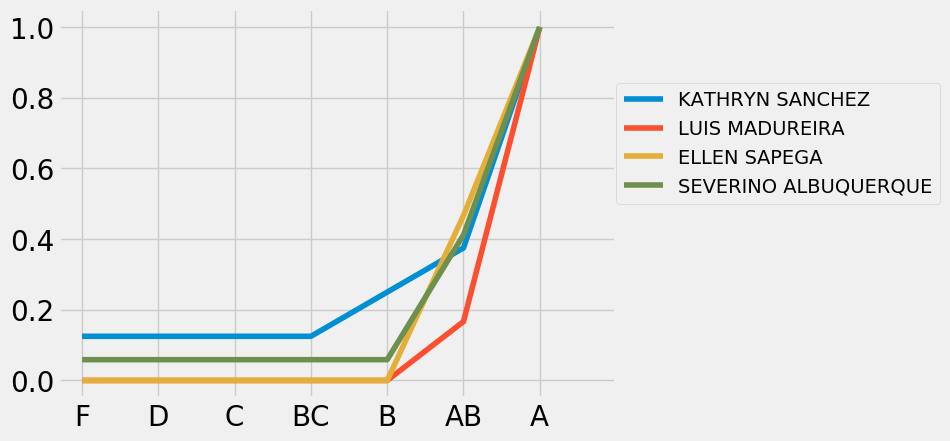

In [108]:
plot_instructor_cdfs(df, "00a17f67-ed74-3d86-9876-9a677ef991e4")

Clearly there are some differences in the CDFs, but how can we quantify this difference? One approach is to generalize the two-sample [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) test to multiple CDFs by finding the maximum difference between any two CDFs. In this case, this maximum difference is $\approx$0.3 between Ellen Sapega and Luis Madureira at the "AB" grade level. Ellen gave more ABs, whereas Luis gave more than 80\% of his students As. But does the data support a real difference between the instructors, or are these differences between the instructors about what you would expect by chance (and therefore likely attributable to other factors such as variation in the quality of students, etc.)?

To attempt to answer this question, we will apply a *permutation test*. To do so, we will take our original data and repeatedly and randomly permute only the instructor label for the course offerings. The other aspects of the data will be kept intact.

In [115]:
brazilian_df = df[df["course_uuid"] == "00a17f67-ed74-3d86-9876-9a677ef991e4"]
brazilian_df

,course_uuid,course_name,course_number,course_offering_uuid,section_type,course_offering_term_code,instructor_id,instructor_name,subject_name,subject_code,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,total_grades
2061178,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,2266ef80-9f5c-3249-b032-9a774a1fd6ff,LEC,1092,2600133,ELLEN SAPEGA,Portuguese (Spanish and Portuguese),782,4,3,0,0,0,0,0,7
2061180,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,5781ca9c-7f01-393f-b577-b74062357397,LEC,1082,1056851,KATHRYN SANCHEZ,Portuguese (Spanish and Portuguese),782,5,1,1,0,0,0,1,8
2061182,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,eef6ab6b-f093-3182-80b7-279201f156e1,LEC,1102,2600699,SEVERINO ALBUQUERQUE,Portuguese (Spanish and Portuguese),782,6,3,0,0,0,0,1,10
2061184,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,a43c7552-cc0d-3a26-9abd-d8b3471b73d3,LEC,1104,2600133,ELLEN SAPEGA,Portuguese (Spanish and Portuguese),782,4,4,0,0,0,0,0,8
2061185,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,2ddb62fc-18ce-3b97-85ad-21eec3d1ca85,LEC,1162,2600104,LUIS MADUREIRA,Portuguese (Spanish and Portuguese),782,5,1,0,0,0,0,0,6
2061187,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,f2e0d0f4-88c8-3104-95df-14a844833c44,LEC,1074,2600699,SEVERINO ALBUQUERQUE,Portuguese (Spanish and Portuguese),782,4,3,0,0,0,0,0,7


In [116]:
permute_column_in_dataframe(brazilian_df, ["instructor_id", "instructor_name"])

In [117]:
brazilian_df

,course_uuid,course_name,course_number,course_offering_uuid,section_type,course_offering_term_code,instructor_id,instructor_name,subject_name,subject_code,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,total_grades
2061178,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,2266ef80-9f5c-3249-b032-9a774a1fd6ff,LEC,1092,2600104,LUIS MADUREIRA,Portuguese (Spanish and Portuguese),782,4,3,0,0,0,0,0,7
2061180,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,5781ca9c-7f01-393f-b577-b74062357397,LEC,1082,2600133,ELLEN SAPEGA,Portuguese (Spanish and Portuguese),782,5,1,1,0,0,0,1,8
2061182,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,eef6ab6b-f093-3182-80b7-279201f156e1,LEC,1102,2600699,SEVERINO ALBUQUERQUE,Portuguese (Spanish and Portuguese),782,6,3,0,0,0,0,1,10
2061184,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,a43c7552-cc0d-3a26-9abd-d8b3471b73d3,LEC,1104,2600699,SEVERINO ALBUQUERQUE,Portuguese (Spanish and Portuguese),782,4,4,0,0,0,0,0,8
2061185,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,2ddb62fc-18ce-3b97-85ad-21eec3d1ca85,LEC,1162,2600133,ELLEN SAPEGA,Portuguese (Spanish and Portuguese),782,5,1,0,0,0,0,0,6
2061187,00a17f67-ed74-3d86-9876-9a677ef991e4,Topics in Luso-Brazilian Literature,640,f2e0d0f4-88c8-3104-95df-14a844833c44,LEC,1074,1056851,KATHRYN SANCHEZ,Portuguese (Spanish and Portuguese),782,4,3,0,0,0,0,0,7


As you can see, the instructor ids and names were randomly shuffled, but the rest of the data structure was kept intact. We can now recompute the instructor CDFs and compare them to what we had before.

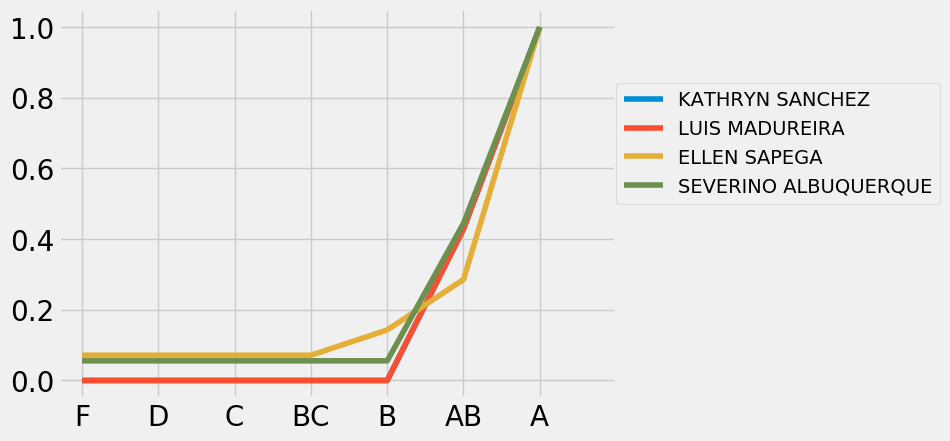

In [120]:
plot_instructor_cdfs(brazilian_df, "00a17f67-ed74-3d86-9876-9a677ef991e4")

This time, the maximum difference seems to be a little smaller than before, perhaps $\approx$0.15. If we repeat this process many times, we can build up a sense of what the distribution of differences would looks like over many randomly permuted datasets. We can then plot the real difference and compare it to the distribution obtained by computing the differences for many randomly permuted datasets.

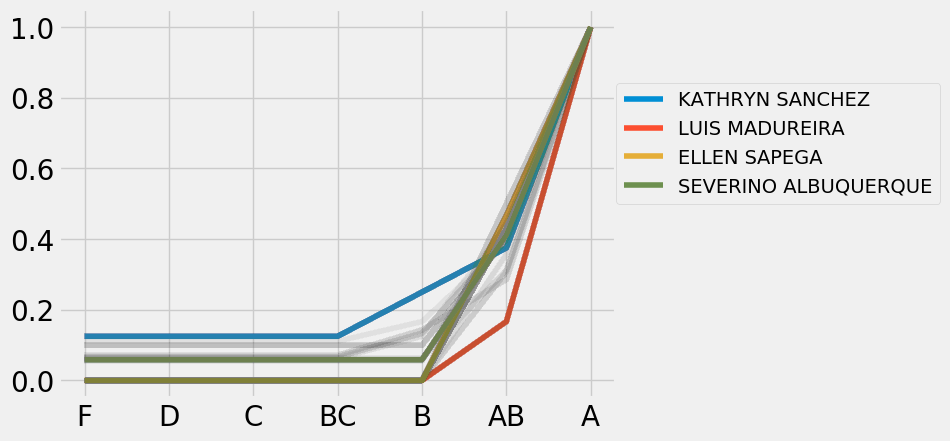

In [125]:
plot_instructor_cdfs(df, "00a17f67-ed74-3d86-9876-9a677ef991e4", 
                     npermutations=100, 
                     plot_all_permuted_cdfs=True, 
                     alpha=0.01)

In the above plot we've represented the CDFs that were obtained by first permuting the data using a light gray shadow. These CDFs appear to cluster together more than the real instructor CDFs, indicating that there may indeed be some significant differences in the ways that the instructors distribute grades. How can we try to quantify the probability that this observed difference is real? We can plot the distribution of differences obtained by permutation and compare that to the real observed difference, which we do below.

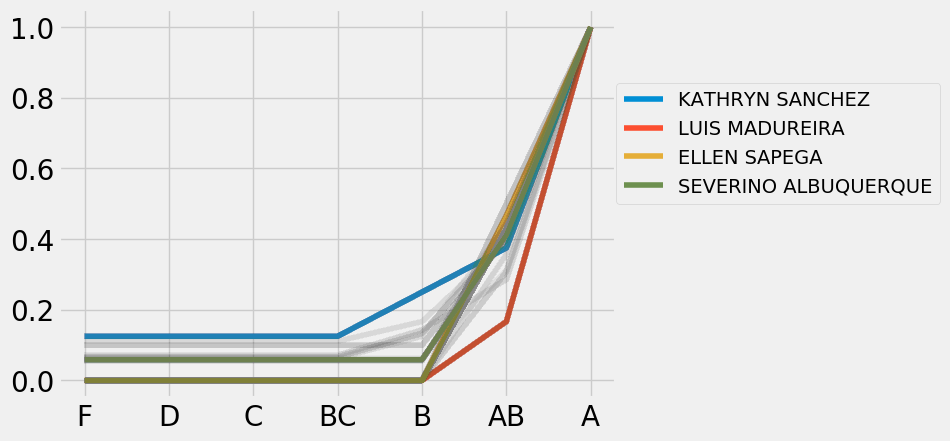

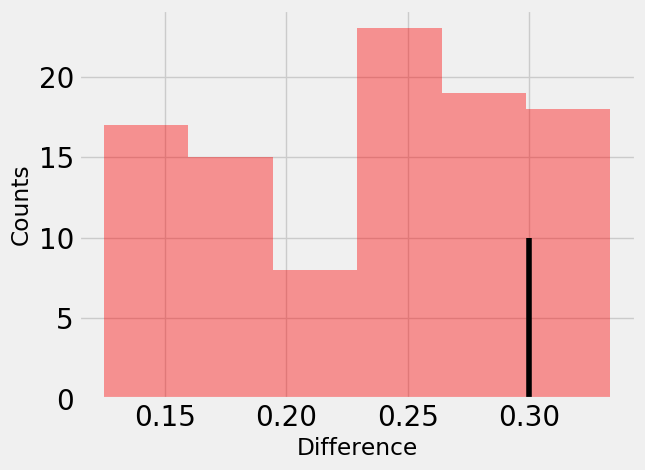

In [131]:
plot_instructor_cdfs(df, "00a17f67-ed74-3d86-9876-9a677ef991e4", 
                     npermutations=100, 
                     plot_all_permuted_cdfs=True,
                     plot_permutation_distribution=True,
                     alpha=0.01)

By plotting the distribution of differences obtained by permutation, we can see that about 17 out of 100 permutations resulted in a difference that was greater than or equal to the real difference, which would give us a p-value of 0.17, i.e., we have about a 17% chance of observing a difference that is as large or greater than the real observed difference even if the instructor labels are randomly assigned (such that the observed differences can therefore not be attributed to the instructors themselves). The null hypothesis, "The instructors do not distribute grades differently" would therefore not be rejected by a classical $\alpha<0.05$ criterion, but it seems more likely than not that at least one pair of instructors do not distribute grades in the same way. We can therefore accept, admittedly with a low degree of certainty in this case, that the alternative hypothesis, "Some instructors distribute grades differently than others" may be true. The closer our pvalue is to 0 (such that the real observed difference will appear as an extreme outlier against the distribution of differences obtained by permutation), the more certain we can be that the alternative hypothesis is true.

We repeated the above analysis for all $\approx$5,000 courses in our cleaned database. Although very useful and generically applicable, the permutation test is fairly computationally intensive. It took several CPU-days to compute pvalues for the 5,000 or so courses

In [ ]:
# results = compare_instructor_grade_distributions_by_permutation(df, 
#                                                                     npermutations=100, 
#                                                                     load_existing_pickle=False, 
#                                                                     print_progress=True)

In [3]:
results = pickle.load(open("all_pvalues_100.pkl", 'rb'))

### Do some subjects have a larger fraction of classes where grades are distributed differently by different instructors than others?

To attempt to answer this question, we will group the pvalues computed above by subject and compute the mean pvalue per subject. To help us understand the level of significance of any differences that we may observe, we will compute confidence intervals using bootstrapping.

In [28]:
pvalue_by_subject_dict = get_pvalues_by_subject(df, results)

A low mean pvalue for a subject means that those subjects tend to have courses that are graded differently by different instructors. Let's which subjects have the highest tendency to distribute grades differently according to the instructor.

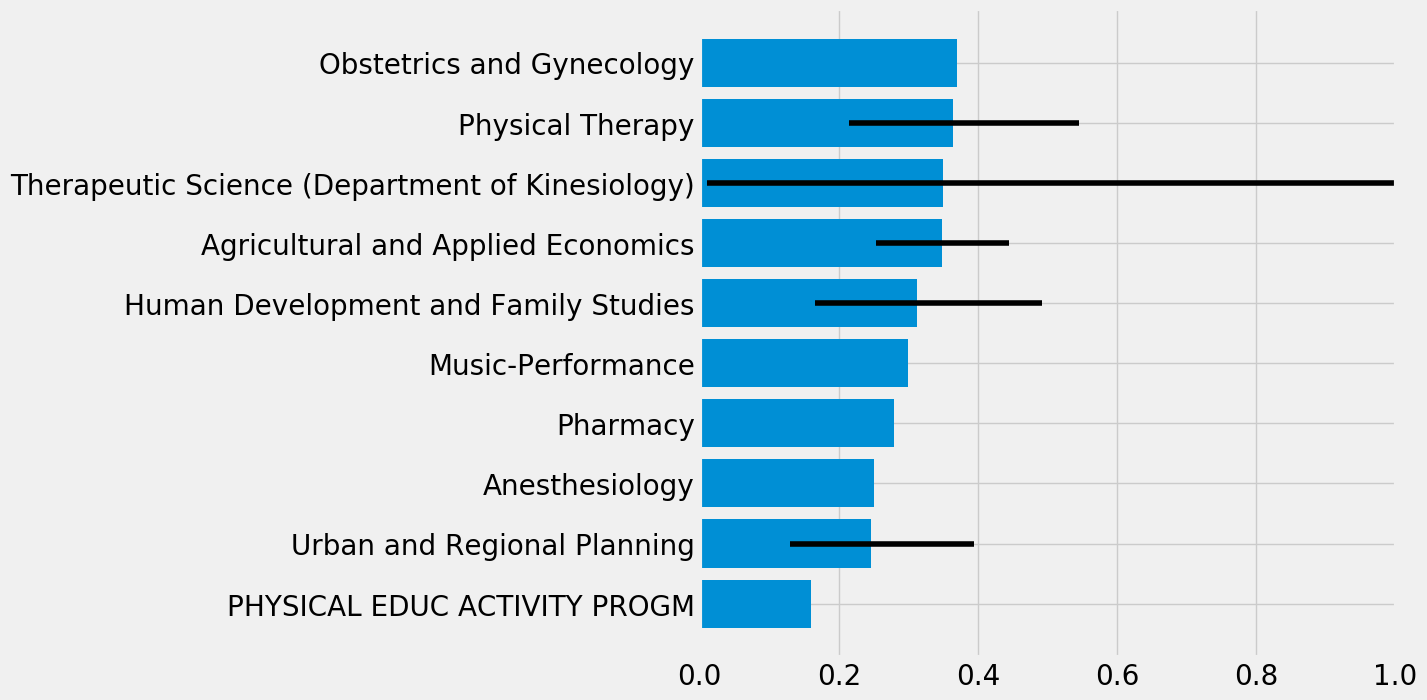

In [82]:
plot_pvalues_by_subject_with_confidence_intervals(pvalue_by_subject_dict, num_to_plot=10)

Apparently physical education grades are fairly subjective. Therapeutic Science has a lower mean pvalue, but also has very wide confidence intervals, which means that it is perhaps unfair to group it in with the rest of the subjects on this list.

In [85]:
pvalue_by_subject_dict["Therapeutic Science (Department of Kinesiology)"]

[0.01, 0.04, 1.0]

As we can see, we only have 3 data points and the values vary quite a bit. More data is needed before we can make any confident conclusions.

A high mean pvalue for a subject means that different instructors are apparently scrupulous about distributing grades in a uniform way, perhaps as a result of a policy that is in place at the department level. Which subjects tend to distribute grades similarly regardless of the instructor?

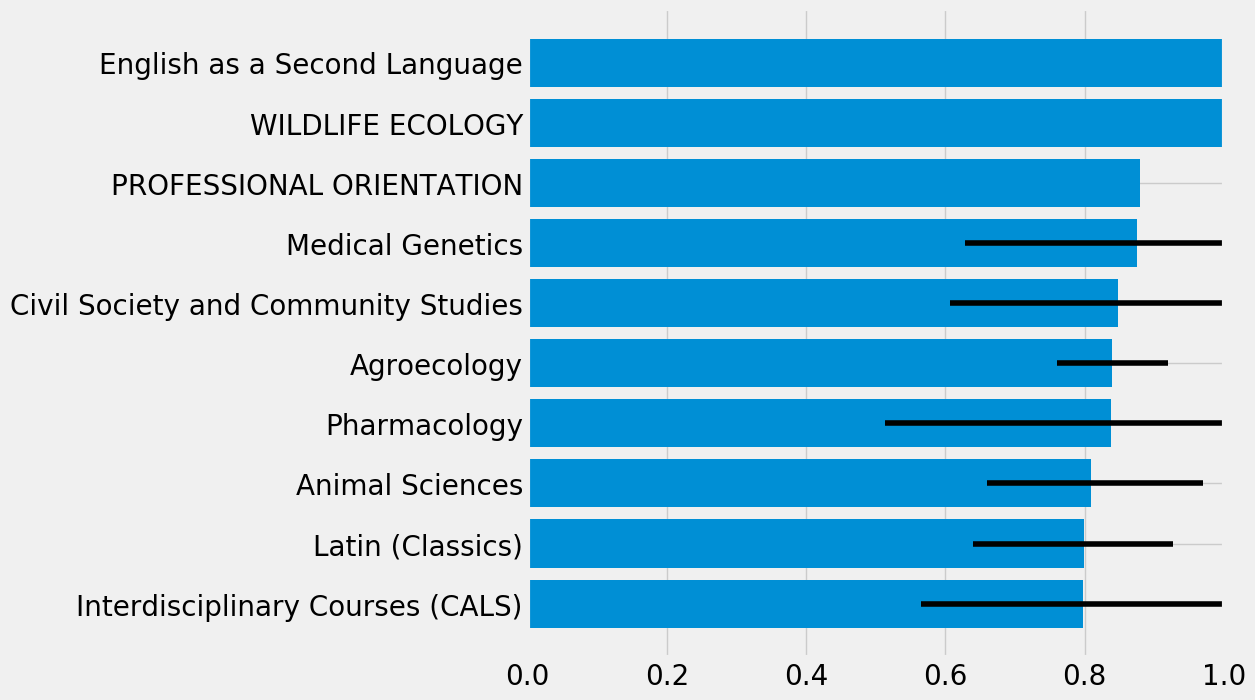

In [83]:
plot_pvalues_by_subject_with_confidence_intervals(pvalue_by_subject_dict, num_to_plot=-10)